# Trading simulation using soft predictions

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import talib

data = pd.read_csv("../data/interim/data_with_target.csv", index_col=0)

# Macro features

macro_tickers = ['VIX', 'WTI_Oil', 'US10Y']  # VIX, WTI Oil, 10Y Treasury

data['VIX_ret'] = data['VIX'].pct_change()
data['WTI_ret'] = data['WTI_Oil'].pct_change()
data['TNX_ret'] = data['US10Y'].pct_change()

data['VIX_5d_mean'] = data['VIX'].rolling(5).mean()
data['WTI_5d_std'] = data['WTI_Oil'].rolling(5).std()


# Market indices features

market_indices = ["GSPC", "NDX", "RUT", "DJI"]

for idx in market_indices:
    data[f'{idx}_return_1d'] = data[idx].pct_change()
    data[f'{idx}_return_5d'] = data[idx].pct_change(5)


# Stock features

data['return_1d'] = data.groupby('Ticker')['Close'].pct_change()
data['return_3d'] = data.groupby('Ticker')['Close'].pct_change(3)
data['return_5d'] = data.groupby('Ticker')['Close'].pct_change(5)
data['return_10d'] = data.groupby('Ticker')['Close'].pct_change(10)

data['ma_5'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=5).mean())
data['ma_20'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).mean())

data['price_ma5_ratio'] = data['Close'] / data['ma_5']
data['price_ma20_ratio'] = data['Close'] / data['ma_20']

data['volume_ratio'] = (
    data['Volume'] / 
    data.groupby('Ticker')['Volume'].transform(lambda x: x.rolling(20).mean())
)

data['price_volume'] = data['return_1d'] * data['Volume']

data['rsi'] = data.groupby('Ticker')['Close'].transform(
    lambda x: talib.RSI(x.values, timeperiod=14)
)

data['macd'] = data.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean() - x.ewm(span=26, adjust=False).mean())
data['macd_signal'] = data.groupby('Ticker')['macd'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
data['macd_hist'] = data['macd'] - data['macd_signal'] 



encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_values = encoder.fit_transform(data[['Ticker']])
new_cols = encoder.get_feature_names_out(['Ticker'])

df_encoded = pd.DataFrame(encoded_values, columns=new_cols, index=data.index)

df = pd.concat(
    [data.drop(columns=['Ticker']), df_encoded],
    axis=1
)


df = df.dropna()

In [2]:
df

,Date,Close,High,Low,Open,Volume,WTI_Oil,US10Y,VIX,DJI,...,Ticker_KO,Ticker_MSFT,Ticker_NEE,Ticker_NVDA,Ticker_PFE,Ticker_QQQ,Ticker_SPY,Ticker_T,Ticker_VTI,Ticker_XOM
380,2020-01-30,78.218910,78.272043,76.982363,77.414674,126743200,52.139999,1.558,15.49,28859.439453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
381,2020-01-30,93.533997,93.643501,92.530502,92.900002,126548000,52.139999,1.558,15.49,28859.439453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
382,2020-01-30,321.387817,323.425711,315.761320,318.604390,6022000,52.139999,1.558,15.49,28859.439453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
383,2020-01-30,29.046370,29.081073,28.343634,28.369663,50542800,52.139999,1.558,15.49,28859.439453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
384,2020-01-30,32.421413,32.452010,31.858413,32.054237,1993923,52.139999,1.558,15.49,28859.439453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25155,2024-12-31,509.896118,516.309303,508.928648,515.551337,29117000,71.720001,4.573,17.35,42544.218750,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25156,2024-12-31,582.599915,587.132835,580.949738,586.407129,57052700,71.720001,4.573,17.35,42544.218750,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
25157,2024-12-31,22.028353,22.105747,21.863890,21.883239,22342800,71.720001,4.573,17.35,42544.218750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25158,2024-12-31,287.925415,290.240280,287.190237,289.912409,3893200,71.720001,4.573,17.35,42544.218750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [3]:
from sklearn.model_selection import train_test_split

tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "NVDA", "JPM", "BAC", "JNJ", "PFE", "DIS", "KO", "BA", "XOM", "BHP", "NEE", "T", "SPY", "QQQ", "IWM", "VTI"]
ticker_columns = [col for col in df.columns if col.startswith('Ticker_')]
macro_features = ['VIX_ret', 'WTI_ret', 'TNX_ret', 'VIX_5d_mean', 'WTI_5d_std'] 
feature_columns = ['return_1d', 'return_3d', 'return_5d', 'volume_ratio', 'rsi', 'macd', 'macd_hist', 'price_ma5_ratio', 'price_ma20_ratio', 'price_volume'] + ticker_columns + macro_features

X = df[feature_columns]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [4]:
# Get the test split for the df that will be used for the simulation later on

cols =  ['Date', 'Close'] + new_cols.tolist()
X_sim = df[cols].copy()
y_sim = df['Target'].copy()

X_train_sim, X_test_sim, y_train_sim, y_test_sim = train_test_split(X_sim, y_sim, test_size=0.2, shuffle=False)


# Undo the one-hot encoding for the trading simulation

encoded_columns = X_test_sim[new_cols]
original_ticker = encoder.inverse_transform(encoded_columns)
X_test_sim['Ticker'] = original_ticker.ravel()
X_test_sim = X_test_sim[['Date', 'Close', 'Ticker']]

In [5]:
import numpy as np

class_counts = y_train.value_counts().to_dict()
n_total = len(y_train)
n_classes = len(class_counts)

# Compute weights
class_weights = {cls: n_total / (count * n_classes) for cls, count in class_counts.items()}
print("Class weights:", class_weights)

weights = y_train.map(class_weights)

Class weights: {2: 0.6645213193885761, 0: 0.7641956748005089, 1: 5.359286293592863}


In [ ]:

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import make_scorer, balanced_accuracy_score

model = XGBClassifier(
    objective='multi:softprob', 
    num_class=3, 
    eval_metric='mlogloss', 
    random_state=42
    )

# Train the model
model.fit(X_train, y_train, sample_weight=weights)

# Make predictions
y_proba = model.predict_proba(X_test)


In [7]:
new_df = X_test_sim.copy()
new_df['Prob_Down'] = y_proba[:, 0]
new_df['Prob_Flat'] = y_proba[:, 1]
new_df['Prob_Up']   = y_proba[:, 2]

In [8]:
new_df

,Date,Close,Ticker,Prob_Down,Prob_Flat,Prob_Up
20204,2024-01-08,61.385715,BHP,0.347207,0.139052,0.513740
20205,2024-01-08,90.342300,DIS,0.384946,0.307134,0.307921
20206,2024-01-08,139.574844,GOOG,0.364324,0.141887,0.493789
20207,2024-01-08,193.472382,IWM,0.310780,0.151358,0.537862
20208,2024-01-08,152.887192,JNJ,0.240969,0.425124,0.333906
...,...,...,...,...,...,...
25155,2024-12-31,509.896118,QQQ,0.407114,0.368649,0.224238
25156,2024-12-31,582.599915,SPY,0.237299,0.579980,0.182721
25157,2024-12-31,22.028353,T,0.320537,0.476995,0.202468
25158,2024-12-31,287.925415,VTI,0.318157,0.464908,0.216935


# Trading simulation

In [9]:
import numpy as np

holding_horizon = 3  # days to hold each position
threshold_flat = 0.5  # skip trades if flat probability is highest

# Step 1: Compute soft positions
new_df['Position'] = new_df['Prob_Up'] - new_df['Prob_Down']

# Set position to 0 if Flat is highest
new_df.loc[new_df[['Prob_Up', 'Prob_Down', 'Prob_Flat']].idxmax(axis=1) == 'Prob_Flat', 'Position'] = 0

# Step 2: Compute forward returns
new_df = new_df.sort_values(['Ticker', 'Date'])
new_df['Forward_Return'] = new_df.groupby('Ticker')['Close'].shift(-holding_horizon) / new_df['Close'] - 1

# Drop last rows with NaN forward returns
new_df = new_df.dropna(subset=['Forward_Return'])

# Step 3: Calculate per-row P&L
new_df['PnL'] = new_df['Position'] * new_df['Forward_Return']

# Step 4: Aggregate portfolio returns per day
portfolio_returns = new_df.groupby('Date')['PnL'].sum().reset_index()
print(portfolio_returns)
portfolio_returns.rename(columns={'PnL': 'Portfolio_Return'}, inplace=True)

# Step 5: Cumulative returns
portfolio_returns['Cumulative_Return'] = portfolio_returns['Portfolio_Return'].cumsum()


           Date       PnL
0    2024-01-08  0.037709
1    2024-01-09  0.009584
2    2024-01-10 -0.049297
3    2024-01-11 -0.048179
4    2024-01-12 -0.029349
..          ...       ...
240  2024-12-19 -0.008599
241  2024-12-20 -0.041932
242  2024-12-23 -0.013453
243  2024-12-24  0.029274
244  2024-12-26  0.089703

[245 rows x 2 columns]


In [10]:
# Sharpe ratio
daily_mean = portfolio_returns['Portfolio_Return'].mean()
daily_std = portfolio_returns['Portfolio_Return'].std()
sharpe_ratio = daily_mean / daily_std * np.sqrt(252)  # annualized

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Total cumulative return: {portfolio_returns['Cumulative_Return'].iloc[-1]:.2%}")

# Per-stock cumulative PnL
per_stock_pnl = new_df.groupby(['Date', 'Ticker'])['PnL'].sum().unstack(fill_value=0)
per_stock_cum = per_stock_pnl.cumsum()

Sharpe Ratio: 0.94
Total cumulative return: 54.52%


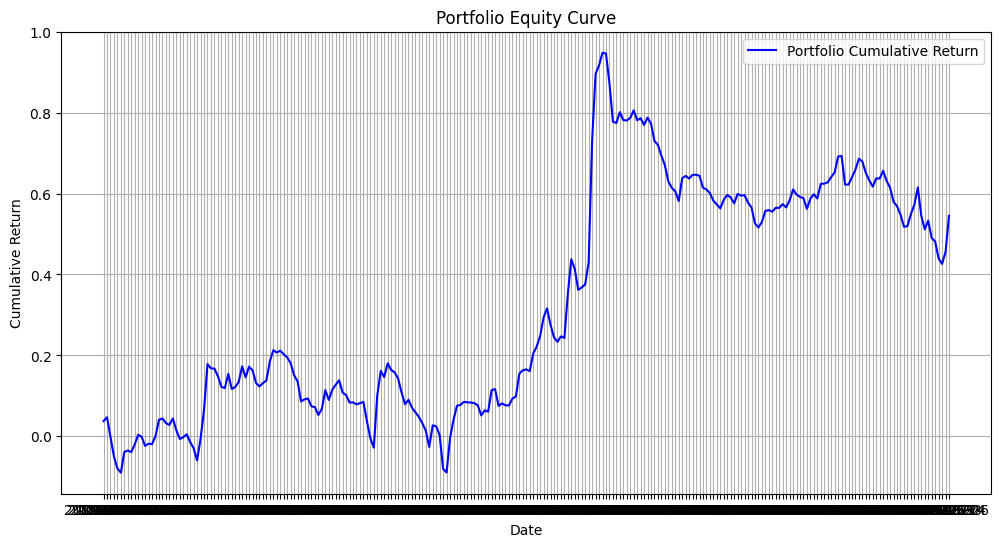

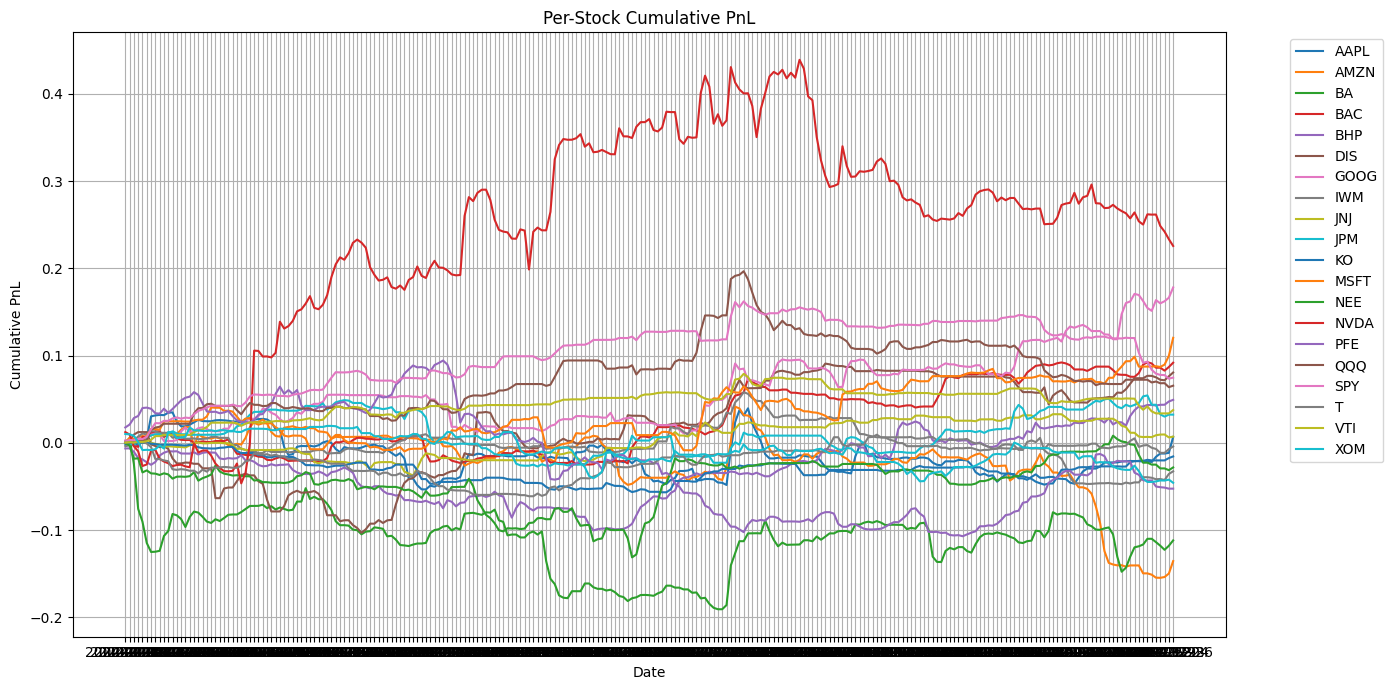

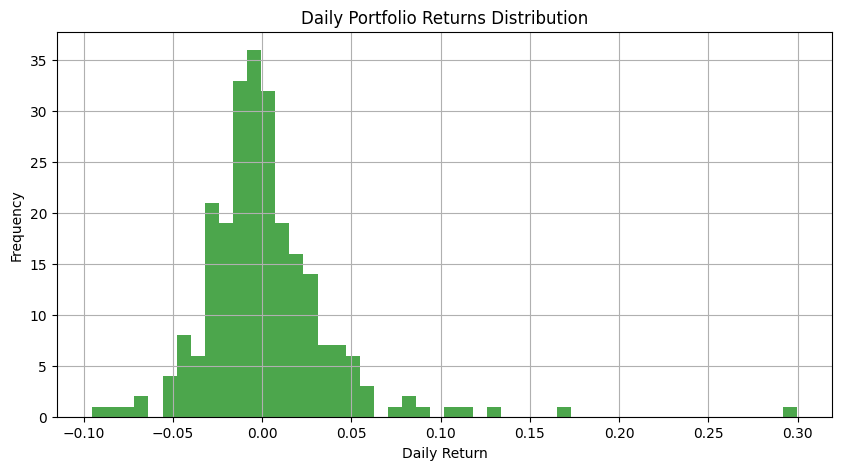

In [11]:
import matplotlib.pyplot as plt

# Portfolio equity curve
plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns['Date'], portfolio_returns['Cumulative_Return'], label='Portfolio Cumulative Return', color='blue')
plt.title('Portfolio Equity Curve')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# Per-stock cumulative PnL
plt.figure(figsize=(14, 7))
for ticker in per_stock_cum.columns:
    plt.plot(per_stock_cum.index, per_stock_cum[ticker], label=ticker)
plt.title('Per-Stock Cumulative PnL')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Daily portfolio returns distribution
plt.figure(figsize=(10, 5))
plt.hist(portfolio_returns['Portfolio_Return'], bins=50, color='green', alpha=0.7)
plt.title('Daily Portfolio Returns Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### Transaction log

In [31]:
def highlight_pnl(val):
    color = 'green' if val > 0 else 'red'
    return f'background-color: {color}'

new_df[['Date', 'Ticker', 'Close', 'Position', 'Forward_Return', 'PnL']].head(40) \
    .sort_values('Date', ascending=True)\
    .style.format({
        'Position': '{:.2f}',
        'Entry_Price': '${:.2f}',
        'Exit_Price': '${:.2f}',
        'Forward_Return': '{:.2%}',
        'PnL': '{:.2%}'
    })\
    .applymap(highlight_pnl, subset=['PnL'])\
    .set_caption("Transaction Log: Key Trades Overview")


C:\Users\maria\AppData\Local\Temp\ipykernel_9764\2307782570.py:14: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(highlight_pnl, subset=['PnL'])\


,Date,Ticker,Close,Position,Forward_Return,PnL
20220,2024-01-09,AAPL,183.585709,-0.03,0.42%,-0.01%
20240,2024-01-10,AAPL,184.626877,0.08,-1.37%,-0.11%
20260,2024-01-11,AAPL,184.031937,0.07,-1.57%,-0.11%
20280,2024-01-12,AAPL,184.359161,0.10,1.46%,0.14%
20300,2024-01-16,AAPL,182.088394,0.36,4.32%,1.55%
20320,2024-01-17,AAPL,181.146347,0.65,6.14%,4.01%
20340,2024-01-18,AAPL,187.046387,-0.06,3.47%,-0.19%
20360,2024-01-19,AAPL,189.951813,-0.01,1.53%,-0.02%
20380,2024-01-22,AAPL,192.262222,-0.60,0.14%,-0.09%
20400,2024-01-23,AAPL,193.541412,-0.30,-1.41%,0.43%
